# Прогнозирование геологических характеристик нефтеносных пластов

**Задача:** предсказать значения параметра песчанистости в точках между скважинами.

**Целевой метрикой является** - корень среднеквадратичной ошибки (RMSE).

*Описание кейса:*

В реальной жизни для изучения свойств целевого пласта на месторождении бурятся скважины, после чего в них опускаются специальные устройства - каротажные зонды. С их помощью проводится запись различных геофизических полей (например, радиоактивность или плотность), создаваемых горными породами. Подобные исследования называются геофизическими исследования скважин - ГИС. На основе полученных данных специалисты петрофизики проводят интерпретацию и сообщают информацию о том, на какой глубине находится пласт-коллектор, который может накапливать и отдавать флюиды. 

На основе полученной интерпретации можно посчитать такое свойство как песчанистость в зоне бурения скважины. Песчанистость - это отношение толщин пластов-коллекторов к общей толщине геологического образования, данная характеристика позволяет геологам делать предположения об экономической эффективности работы с этим месторождением. К сожалению, бурение скважин является очень дорогостоящей операцией, поэтому предлагается использовать различные алгоритмы картопостроения с целью прогноза свойств в межскважинном пространстве.


В предоставленном наборе данных имеется информация о 10% скважинных данных (в реальной жизни их может быть менее 1% от площади месторождения), используя которые, нужно построить алгоритм, который бы предсказывал значения песчанистости в точках с отсутствующими значениями.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import seaborn as sns
import plotly
import plotly.graph_objs as go

from sklearn.manifold import TSNE

import random

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

import math

import scipy
from scipy.spatial import cKDTree

from sklearn.linear_model import ElasticNetCV, ElasticNet

from xgboost import XGBRegressor, plot_importance

from sklearn import neighbors

from sklearn.linear_model import LinearRegression, LogisticRegression,ARDRegression, BayesianRidge

from sklearn.preprocessing import PolynomialFeatures

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor,BaggingRegressor,StackingRegressor,StackingRegressor

from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.svm import LinearSVR

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

%matplotlib inline
sns.set(font_scale = 1.5) 


# Чтение и информация о данных

Известные значения песчанистости:

In [ ]:
data = pd.read_csv("Training_wells.csv")
data.head(5)

,Well,X,Y,NTG
0,201-907,201,907,0.2006
1,201-914,201,914,0.3624
2,201-924,201,924,0.4381
3,202-922,202,922,0.4289
4,202-925,202,925,0.4021


X, Y - координаты точки, NTG - значение песчанистости в ней.

In [ ]:
data.shape

(138, 4)

Пропусков нет (что логично), столбцы в форматах int и float, т.е. сразу готовы для обучения.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138 entries, 0 to 137
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Well    138 non-null    object 
 1   X       138 non-null    int64  
 2   Y       138 non-null    int64  
 3   NTG     138 non-null    float64
dtypes: float64(1), int64(2), object(1)
memory usage: 4.4+ KB


In [ ]:
data.describe()

,X,Y,NTG
count,138.000000,138.000000,138.000000
mean,223.195652,916.630435,0.325720
std,13.590926,8.765456,0.072432
min,201.000000,901.000000,0.177000
25%,211.000000,909.000000,0.270175
50%,222.500000,917.000000,0.325900
75%,236.500000,924.000000,0.377475
max,246.000000,930.000000,0.562500


Датасет с пропущенными значениями:

In [ ]:
result = pd.read_csv("Empty_part.csv")
result.head(2)

,Well,X,Y
0,201-901,201,901
1,201-902,201,902


# Графики

Посмотрим на геометрическое расположение точек.

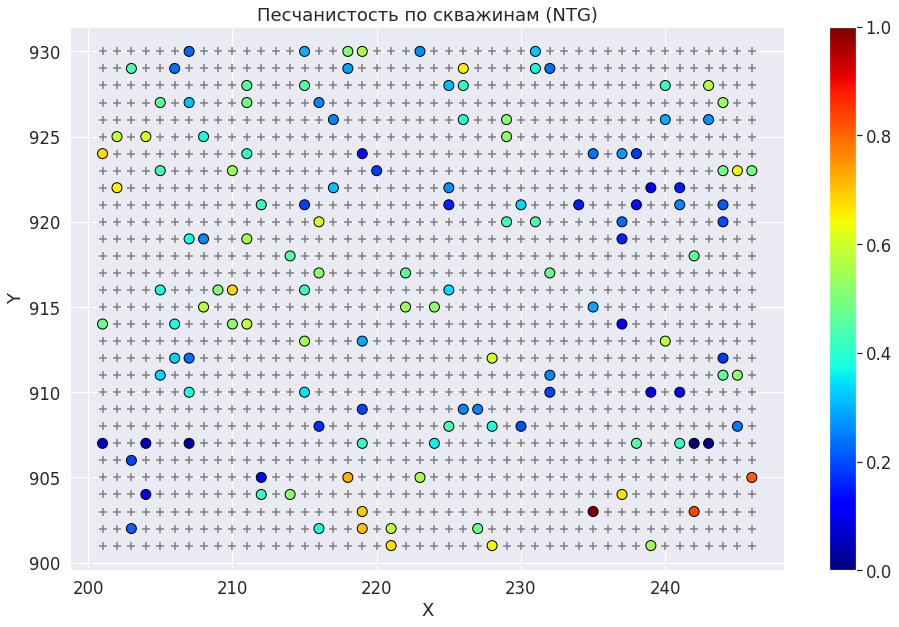

In [ ]:
fig, ax= plt.subplots(figsize=(16, 10))
plt.set_cmap('jet')
plt.title('Песчанистость по скважинам (NTG)')
plt.scatter(data.X, data.Y, c = data.NTG, marker='o', lw = 1, edgecolors='black', s = 100)
plt.scatter(result.X, result.Y, marker='+' , s=60, c='gray')
plt.xlabel('X')
plt.ylabel('Y')
plt.colorbar()
plt.show()

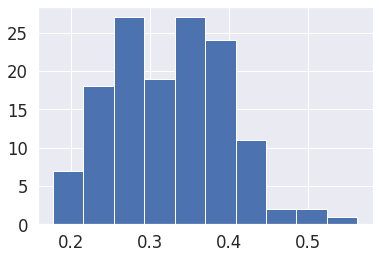

In [ ]:
plt.hist(data.NTG)
None

Корреляция исходных признаков

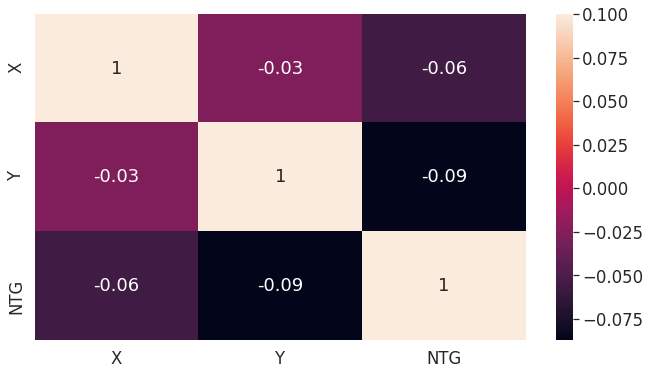

In [ ]:
f, ax = plt.subplots(figsize=(11, 6))
sns.heatmap(data.corr(), vmax=.1, annot=True,fmt='.1g')
None

Графики распределения песчанистости от координаты.

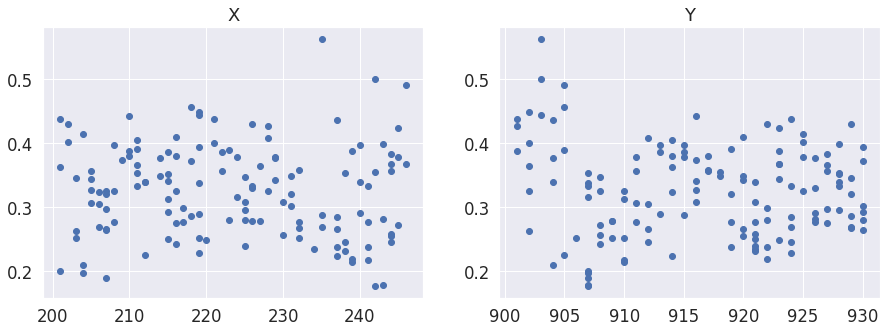

In [ ]:
plt.figure(figsize = (15,5))
for idx,col in enumerate(data[['X','Y']]):
    plt.subplot(1,2,idx+1)
    plt.scatter(data[col], data.NTG)
    #plt.xticks(rotation=45)
    plt.title(col)
None

# Матрица песчанистости по координатам

In [ ]:
NTG_matrix = data.groupby(['X', 'Y'])['NTG'].aggregate('mean').unstack().add_prefix("Y=").reset_index()
#NTG_matrix.fillna(NTG_matrix.mean())
NTG_matrix.head(5)

Y,X,Y=901,Y=902,Y=903,Y=904,Y=905,Y=906,Y=907,Y=908,Y=909,Y=910,Y=911,Y=912,Y=913,Y=914,Y=915,Y=916,Y=917,Y=918,Y=919,Y=920,Y=921,Y=922,Y=923,Y=924,Y=925,Y=926,Y=927,Y=928,Y=929,Y=930
0,201,NaN,NaN,NaN,NaN,NaN,NaN,0.2006,NaN,NaN,NaN,NaN,NaN,NaN,0.3624,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.4381,NaN,NaN,NaN,NaN,NaN,NaN
1,202,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.4289,NaN,NaN,0.4021,NaN,NaN,NaN,NaN,NaN
2,203,NaN,0.2628,NaN,NaN,NaN,0.2517,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.3452,NaN
3,204,NaN,NaN,NaN,0.2092,NaN,NaN,0.1974,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.4136,NaN,NaN,NaN,NaN,NaN
4,205,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.3061,NaN,NaN,NaN,NaN,0.3268,NaN,NaN,NaN,NaN,NaN,NaN,0.3431,NaN,NaN,NaN,0.3568,NaN,NaN,NaN


Корреляция для координат

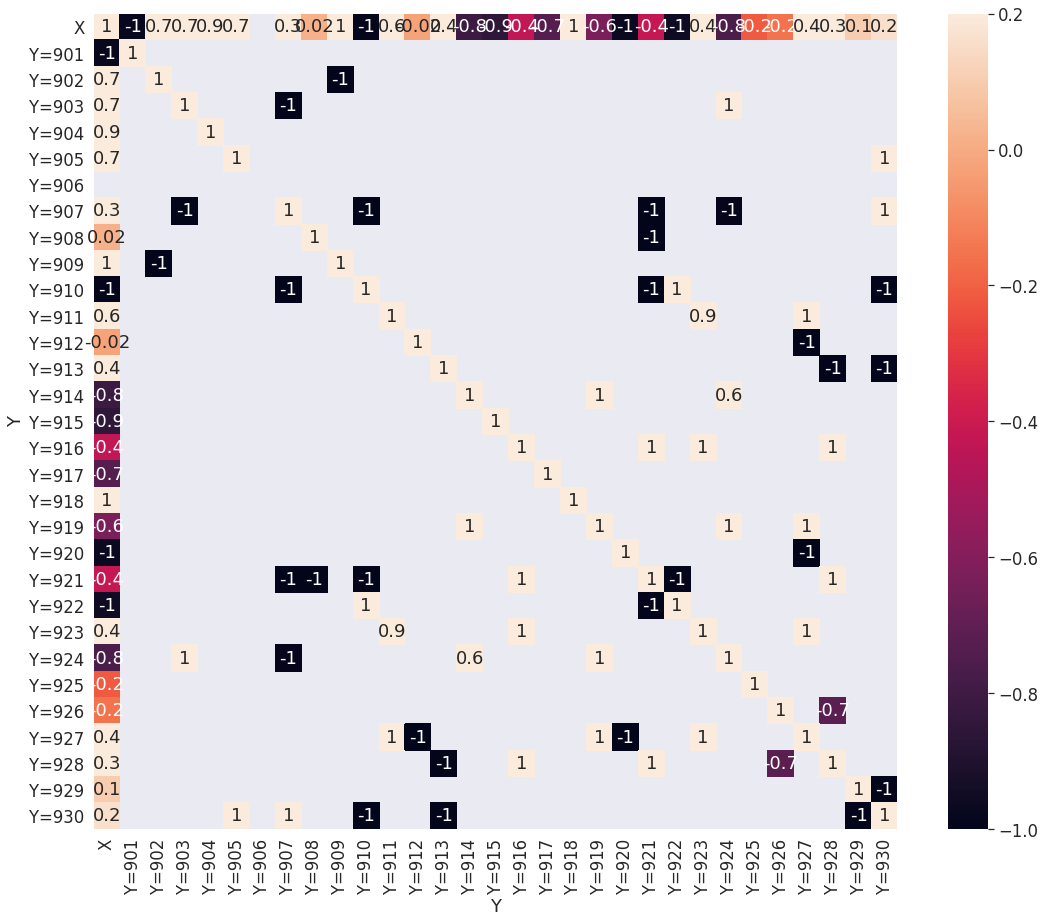

In [ ]:
f, ax = plt.subplots(figsize=(18, 15))
sns.heatmap(NTG_matrix.corr(), vmax=.2, annot=True,fmt='.1g')
None

# Визуализация в 3D

In [ ]:
fig = px.scatter_3d(data, x='X', y='Y', z='NTG', color='NTG')
fig.update_layout( title='3Д график',
    width=900, height=600,
    margin=dict(l=65, r=50, b=10, t=90))
fig.show()

# Генерация признаков

In [ ]:
full_data = pd.concat([data,result], axis=0, sort = False).reset_index(drop=True)

In [ ]:
full_data

,Well,X,Y,NTG
0,201-907,201,907,0.2006
1,201-914,201,914,0.3624
2,201-924,201,924,0.4381
3,202-922,202,922,0.4289
4,202-925,202,925,0.4021
...,...,...,...,...
1375,246-926,246,926,NaN
1376,246-927,246,927,NaN
1377,246-928,246,928,NaN
1378,246-929,246,929,NaN


Добавим новые признаки

In [ ]:
full_data["distance"] = np.sqrt((full_data.X - full_data.X.min())**2 + (full_data.Y-full_data.Y.min())**2)
full_data["center"] = np.sqrt((full_data.X-full_data.X.mean())**2 + (full_data.Y-full_data.Y.mean())**2) 
full_data["angle"] = [math.degrees(math.atan((full_data.X[i]-200)/(full_data.Y[i]-900))) for i in range(1380)]
full_data["outside"] = np.where((full_data.X==201) | (full_data.X==246) |(full_data.Y==901)|(full_data.Y==930),1,0)
full_data["in_center"] = np.where((full_data.X>216) & (full_data.X<230) & (full_data.Y>920) &(full_data.Y<930),1,0)
full_data["xy"] = full_data.X*full_data.Y

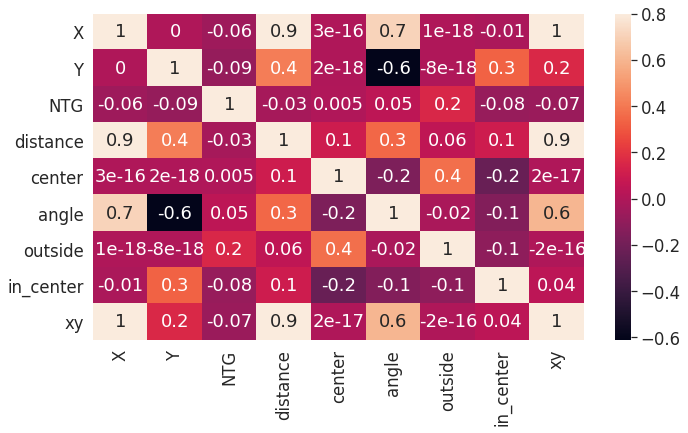

In [ ]:
f, ax = plt.subplots(figsize=(11, 6))
sns.heatmap(full_data.corr(), vmax=.8, annot=True,fmt='.1g')
None

Создадим признаковое пространство по имеющимся данным.
Для кажой имеющейся скважины мы можем определить расстояние до ближайших точек и песчанистость в них. Эта информация будет использоваться в качестве признаков, на основе которых будет строиться предсказание

In [ ]:
ntg_coordinates = full_data[['X', 'Y']]
well_distance,index = cKDTree(data[['X', 'Y']]).query(ntg_coordinates, k = 4)

well_distance = pd.DataFrame(well_distance, columns=['0nei_dist','1nei_dist','2nei_dist','3nei_dist'])

ntg_index = []
for ind in index:
    ntg_index.append(data.loc[ind, 'NTG'].values)
ntg_index = pd.DataFrame(ntg_index, columns=['0nei_ntg','1nei_ntg','2nei_ntg','3nei_ntg'] )

Соберем матрицу признаков вместе.

In [ ]:
features = pd.concat([full_data.drop(['Well', 'NTG'], axis=1),well_distance.iloc[:,1:], ntg_index.iloc[:,1:]], axis=1)

In [ ]:
features

,X,Y,distance,center,angle,outside,in_center,xy,1nei_dist,2nei_dist,3nei_dist,1nei_ntg,2nei_ntg,3nei_ntg
0,201,907,6.000000,24.052027,8.130102,1,0,182307,2.236068,3.000000,4.242641,0.2517,0.1974,0.2092
1,201,914,13.000000,22.549945,4.085617,1,0,183714,4.472136,5.000000,5.000000,0.3268,0.3061,0.3228
2,201,924,23.000000,24.052027,2.385944,1,0,185724,1.414214,2.236068,3.162278,0.4021,0.4289,0.4136
3,202,922,21.023796,22.461077,5.194429,0,0,186244,2.236068,3.000000,3.162278,0.4381,0.4021,0.3431
4,202,925,24.020824,23.505319,4.573921,0,0,186850,1.414214,2.000000,3.000000,0.4381,0.4136,0.4289
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1375,246,926,51.478151,24.829418,60.524111,1,0,227796,3.000000,3.000000,3.162278,0.2816,0.3667,0.4239
1376,246,927,51.971146,25.268558,59.588919,1,0,228042,3.162278,3.162278,4.000000,0.2816,0.3981,0.3667
1377,246,928,52.478567,25.739075,58.671307,1,0,228288,3.000000,3.605551,5.000000,0.3981,0.2816,0.3667
1378,246,929,53.000000,26.239284,57.771243,1,0,228534,3.162278,4.242641,6.000000,0.3981,0.2816,0.3667


Обратная разбивка

In [ ]:
data_train = features.iloc[:138]
data_predict = features.iloc[138:]

print(data_train.shape)
print(data_predict.shape)

(138, 14)
(1242, 14)


# Подготовка

In [ ]:
X, y = data_train, data.NTG

In [ ]:
X.shape, y.shape

((138, 14), (138,))

Так как данных очень мало, не будем делать train_test_split. Результат будем оценивать по кросс-валидции и визуально.

# BaseLine

In [ ]:
def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

1. Заполнить средними

In [ ]:
y_mean = np.arange(len(y), dtype=float)
y_mean = np.full_like(y_mean, data.NTG.mean())
print("RMSE mean:", rmse(y_mean,y))

RMSE mean: 0.07216885479699338


2. Рандомные значения

In [ ]:
y_rand = np.random.uniform(low=data.NTG.min(), high=data.NTG.max(), size=len(data.NTG))
print("RMSE random:", rmse(y_rand,data.NTG))

RMSE random: 0.14066874442077207


## Отрисовка результата

In [ ]:
def predict_and_draw(X, estimator, model=None):
    X_pred = estimator.predict(X)
    
    result['NTG'] = X_pred
    full = pd.concat([data,result]).sort_values(by = ["X","Y"])

    fig, ax= plt.subplots(figsize=(16, 10))
    plt.title(f'Карта спрогнозированной песчанистости (NTG), {model}')
    lims = dict(cmap='RdBu_r', vmin=0.1, vmax=0.6)
    
    plt.scatter(full.X, full.Y, c = full.NTG, s=280, marker='s', lw = 0.92,**lims)
    plt.colorbar()
    plt.scatter(data.X, data.Y, c = data.NTG, marker='o', lw = 1, edgecolors='black', s = 200, **lims)
    plt.xlabel('X')
    plt.ylabel('Y')
    
    plt.show()

# Интерполяция

In [ ]:
from scipy.interpolate import Rbf, InterpolatedUnivariateSpline

Подберем параметры RBF интерполяции, которые лучше всего аппроксимируют данные точки.

In [ ]:
X_train, x_test, ntg_train, ntg_test = train_test_split(data[['X','Y']], data.NTG,test_size=0.33, random_state=42)

Функуия для получения предсказания

In [ ]:
def get_interpolation_result(z):
    ntg = z.transpose().flatten()

    sorted_data = full_data[['X', 'Y','NTG']].sort_values(['X', 'Y']).reset_index(drop=True)
    indexes_not_empty = sorted_data[sorted_data.NTG.notna()].index  #isna чтобы получить результаты для предсказания
    indexes_empty = sorted_data[sorted_data.NTG.isna()].index
   
    ntg_not_empty = ntg[indexes_not_empty]
    ntg_empty = ntg[indexes_empty]

    return (ntg_not_empty, ntg_empty)

In [ ]:
#'multiquadric': sqrt((r/self.epsilon)**2 + 1)
#'inverse': 1.0/sqrt((r/self.epsilon)**2 + 1)
#'gaussian': exp(-(r/self.epsilon)**2)
#'linear': r
#'cubic': r**3
#'quintic': r**5
#'thin_plate': r**2 * log(r)

In [ ]:
edgeY = sorted(features.Y.unique())
edgeX = sorted(features.X.unique())

XI, YI = np.meshgrid(edgeX, edgeY)

In [ ]:
from sklearn.model_selection import ParameterGrid

In [ ]:
rbf_parameters = {
    'function':['multiquadric','inverse','gaussian','cubic','quintic','thin_plate'],
    'epsilon':[0.5, 1, 1.5, 2, 2.5],
    'smooth':[0,0.01, 0.01, 0.1,0.15,0.2]
}

In [ ]:
error = []
par = []
for i in range(len(list(ParameterGrid(rbf_parameters))) ):
    rbf = Rbf(X_train.X, X_train.Y, ntg_train, **list(ParameterGrid(rbf_parameters))[i])
    ZI = rbf(XI, YI)
    ntg_ = get_interpolation_result(ZI)
    r = rmse(data.NTG, ntg_[0])
    error.append(r)
    par.append(list(ParameterGrid(rbf_parameters))[i])
    
    
   # print(list(ParameterGrid(rbf_parameters))[i])
   # print(rmse(data.NTG, ntg_[0]))
 
print("Лучший результат rmse =",min(error))
print('при следующих параметрах:', par[np.argmin(error)])

Лучший результат rmse = 0.0383636918925398
при следующих параметрах: {'epsilon': 0.5, 'function': 'multiquadric', 'smooth': 0.2}


In [ ]:
# use RBF
rbf = Rbf(data.X, data.Y, data.NTG, epsilon=0.5, function = "multiquadric", smooth = 0.2)
ZI = rbf(XI, YI)

ntg = ZI.transpose().flatten()

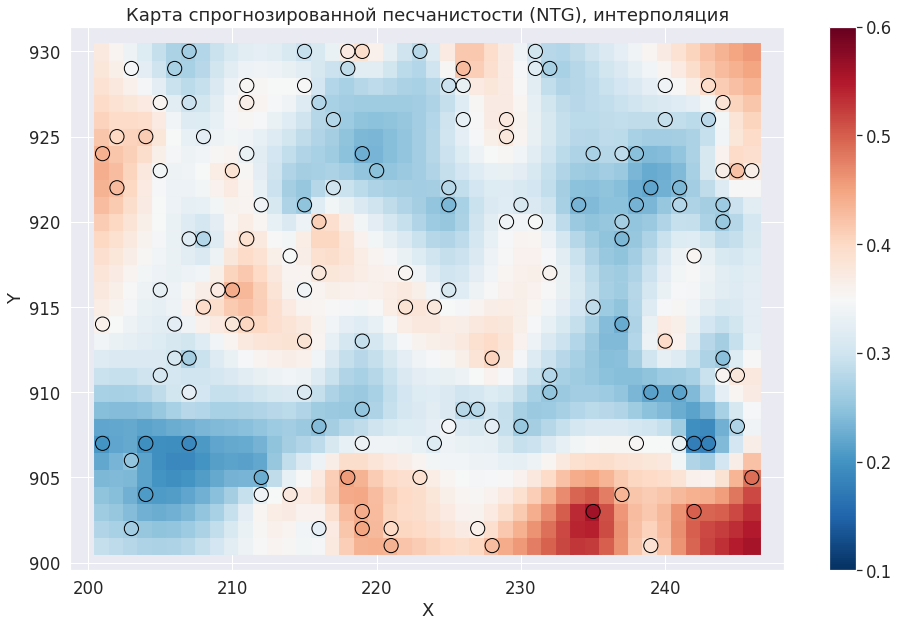

In [ ]:
fig, ax= plt.subplots(figsize=(16, 10))
plt.title(f'Карта спрогнозированной песчанистости (NTG), интерполяция')
lims = dict(cmap='RdBu_r', vmin=0.1, vmax=0.6)
    
plt.scatter(features.sort_values(['X','Y']).X, features.sort_values(['X','Y']).Y, c = ntg, s=280, marker='s', lw = 0.92,**lims)
plt.colorbar()
plt.scatter(data.X, data.Y, c = data.NTG, marker='o', lw = 1, edgecolors='black', s = 200, **lims)
plt.xlabel('X')
plt.ylabel('Y')
    
plt.show()

In [ ]:
interpolation_prediction = get_interpolation_result(ZI)[1]

In [ ]:
len(interpolation_prediction)

1242

# Алгоритмы (Классические модели)

### 1. XGB

In [ ]:
params = {
        'booster': ['gbtree', 'gblinear', 'dart'],
       # 'objective': ['reg:squarederror'],
        'min_child_weight': [1,2, 3, 6],
     #   'subsample': [0.1,0.5, 0.7, 1],
      #  'colsample_bytree': [ 0.7, 1],
        'max_depth': [1, 2,3,6,10],
        'n_estimators': [ 10,50,100],
        'learning_rate': [  0.1, 0.2, 0.3],
     #   'colsample_bylevel' : [ 0.7, 1],
        }

In [ ]:
xgb = GridSearchCV(XGBRegressor(), params, n_jobs=-1, cv=5, verbose=3, refit=True, scoring='neg_root_mean_squared_error')

In [ ]:
xgb.fit(X, y)

Fitting 5 folds for each of 540 candidates, totalling 2700 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 826 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 2106 tasks      | elapsed:   28.7s


[07:09:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=-1)]: Done 2700 out of 2700 | elapsed:   40.2s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_...
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'booster': ['gbtree', 'gblinear', 'dart'],
                         'learning_rate': [0.1, 0.2, 0.3],
             

In [ ]:
best_xgb = xgb.best_estimator_
best_xgb

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.3, max_delta_step=0,
             max_depth=1, min_child_weight=6, missing=None, n_estimators=10,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [ ]:
rmse(y, xgb.predict(X))

0.05211085246320738

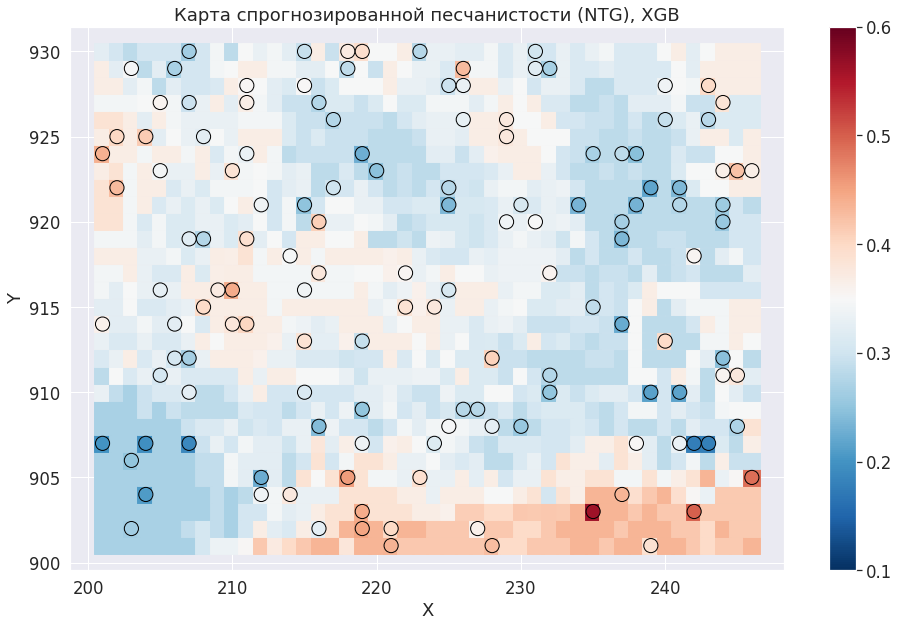

In [ ]:
predict_and_draw(data_predict, xgb, model='XGB')

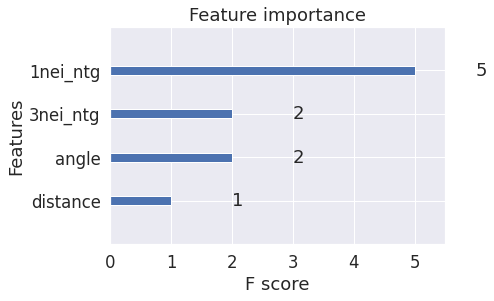

In [ ]:
plot_importance(best_xgb)

## 2. Ridge

In [ ]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [ ]:
ridge = make_pipeline(StandardScaler(), RidgeCV(cv=5, scoring='neg_root_mean_squared_error', fit_intercept = True))

In [ ]:
ridge.fit(X, y)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('ridgecv',
                 RidgeCV(alphas=array([ 0.1,  1. , 10. ]), cv=5,
                         fit_intercept=True, gcv_mode=None, normalize=False,
                         scoring='neg_root_mean_squared_error',
                         store_cv_values=False))],
         verbose=False)

In [ ]:
rmse(y, ridge.predict(X))

0.05344124982923728

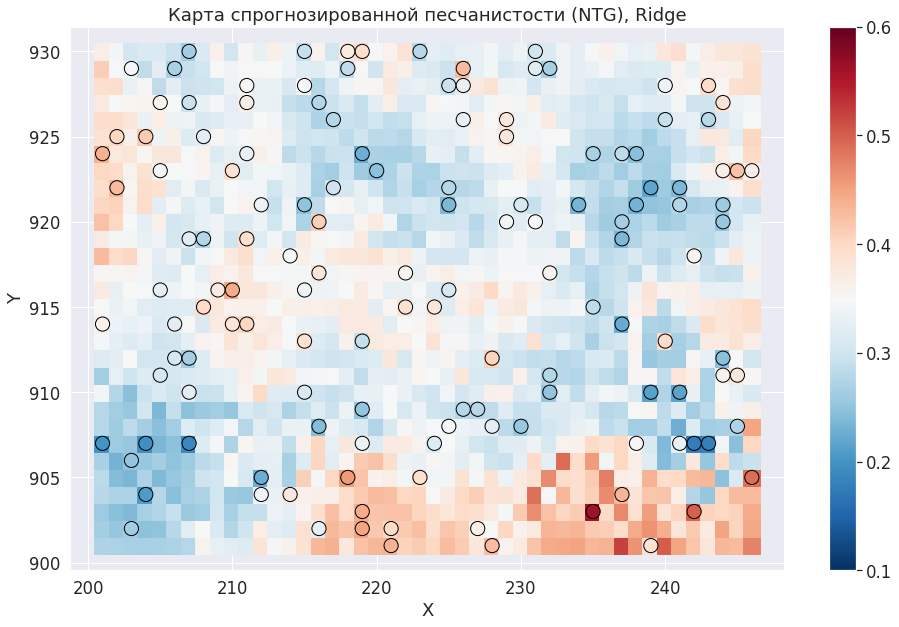

In [ ]:
predict_and_draw(data_predict, ridge, model='Ridge')

## 3. Наивный Байес

Bayesian ridge

In [ ]:
params = {
        'n_iter': [100, 200,300,500],
        'alpha_1':[1e-7,1e-6,3e-6, 1e-5,1e-3,1],
        'alpha_2':[1e-7,1e-6,3e-6, 1e-5,1e-3,1],
        'lambda_1':[1e-7,1e-6,3e-6, 1e-5,1e-3,1],
        'lambda_2':[1e-7,1e-6,3e-6, 1e-5,1e-3,1]
        }

In [ ]:
br = make_pipeline(StandardScaler(), GridSearchCV(BayesianRidge(), params, n_jobs=-1, cv=5, verbose=2, refit=True, scoring='neg_root_mean_squared_error'))

In [ ]:
br.fit(X, y)

Fitting 5 folds for each of 5184 candidates, totalling 25920 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 1084 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 8828 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done 21820 tasks      | elapsed:   42.9s
[Parallel(n_jobs=-1)]: Done 25920 out of 25920 | elapsed:   50.7s finished


Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('gridsearchcv',
                 GridSearchCV(cv=5, error_score=nan,
                              estimator=BayesianRidge(alpha_1=1e-06,
                                                      alpha_2=1e-06,
                                                      alpha_init=None,
                                                      compute_score=False,
                                                      copy_X=True,
                                                      fit_intercept=True,
                                                      lambda_1=1e-06,
                                                      lambda_2=1e-06,
                                                      lambda_init=None,
                                                      n_iter=300,
                                                      normalize=False,
       

In [ ]:
rmse(y, ridge.predict(X))

0.05344124982923728

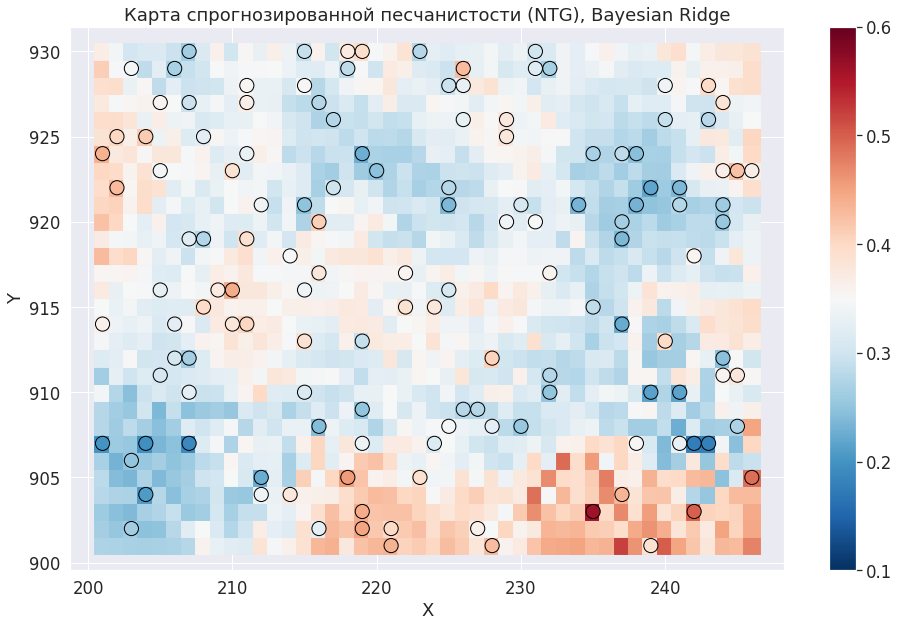

In [ ]:
predict_and_draw(data_predict, ridge, model='Bayesian Ridge')

## 4. KNN

In [ ]:
params = {'n_neighbors':[2, 3, 4, 5]}

knn = make_pipeline(StandardScaler(), GridSearchCV(neighbors.KNeighborsRegressor(), params, cv=5))


knn.fit(X,y)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('gridsearchcv',
                 GridSearchCV(cv=5, error_score=nan,
                              estimator=KNeighborsRegressor(algorithm='auto',
                                                            leaf_size=30,
                                                            metric='minkowski',
                                                            metric_params=None,
                                                            n_jobs=None,
                                                            n_neighbors=5, p=2,
                                                            weights='uniform'),
                              iid='deprecated', n_jobs=None,
                              param_grid={'n_neighbors': [2, 3, 4, 5]},
                              pre_dispatch='2*n_jobs', refit=True,
                              return

In [ ]:
rmse(y, knn.predict(X))

0.04892723322163882

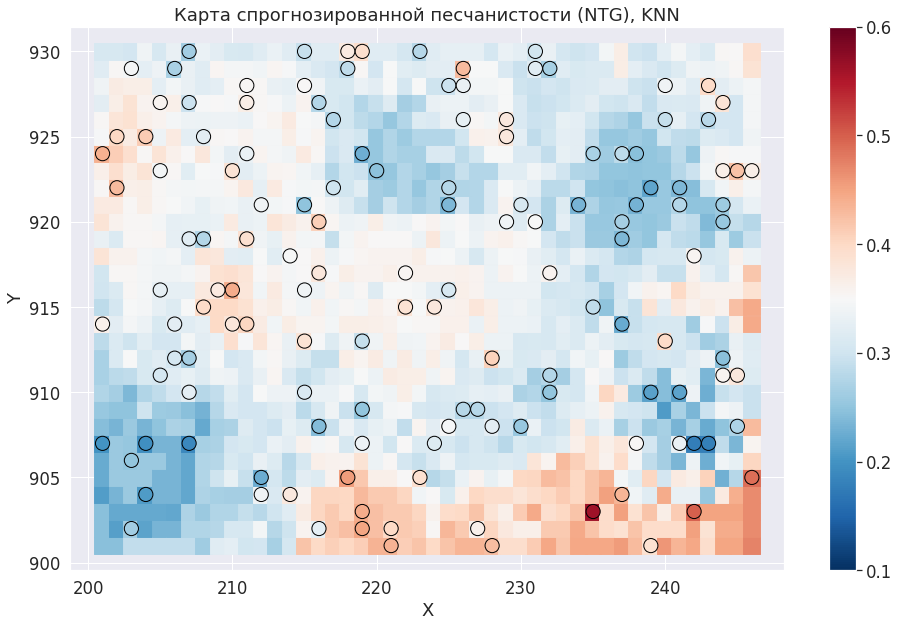

In [ ]:
predict_and_draw(data_predict, knn, model='KNN')

## 5. Полиномиальная регрессия

Дает не особо хороший результат

In [ ]:
for deg in range(2,7):
    search_poly = make_pipeline(StandardScaler(),PolynomialFeatures(degree=deg), RidgeCV(cv=5, scoring='neg_root_mean_squared_error', fit_intercept = True))
    search_poly.fit(X, y)
    print(f"Степень полинома = {deg}, RMSE = {rmse(y, search_poly.predict(X))}")

Степень полинома = 2, RMSE = 0.035392192629247074
Степень полинома = 3, RMSE = 0.012835786569439232
Степень полинома = 4, RMSE = 0.004079859329059503
Степень полинома = 5, RMSE = 0.0016264443289978703
Степень полинома = 6, RMSE = 0.0006946839177709401


In [ ]:
poly = make_pipeline(StandardScaler(),PolynomialFeatures(degree=5), RidgeCV(cv=5, scoring='neg_root_mean_squared_error', fit_intercept = True))

In [ ]:
poly.fit(X, y)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('polynomialfeatures',
                 PolynomialFeatures(degree=5, include_bias=True,
                                    interaction_only=False, order='C')),
                ('ridgecv',
                 RidgeCV(alphas=array([ 0.1,  1. , 10. ]), cv=5,
                         fit_intercept=True, gcv_mode=None, normalize=False,
                         scoring='neg_root_mean_squared_error',
                         store_cv_values=False))],
         verbose=False)

In [ ]:
rmse(y, poly.predict(X))

0.0016264443289978703

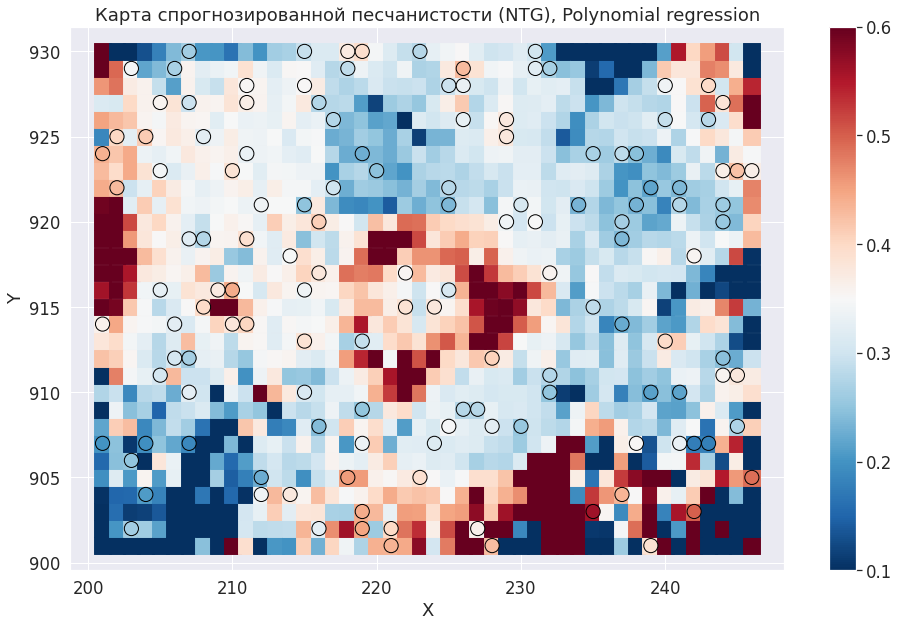

In [ ]:
predict_and_draw(data_predict, poly, model='Polynomial regression')

## 6. SVM


In [ ]:
from sklearn.svm import LinearSVR, SVR

In [ ]:
params = {
        'kernel':['poly', 'rbf', 'sigmoid','linear'],
        'degree':[3],
        #'coef0':[0.0001,0.001,0.01,0.1],
        'C': [1000],
        'epsilon':[0.00001], 
       # 'gamma':[1e-8] 
        }

In [ ]:
svr = make_pipeline(StandardScaler(), GridSearchCV(SVR(), params, n_jobs=-1, cv=5, verbose=2, refit=True, scoring='neg_root_mean_squared_error'))

In [ ]:
%%time
svr.fit(X, y)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  5.1min finished


CPU times: user 23.6 s, sys: 155 ms, total: 23.7 s
Wall time: 5min 26s


Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('gridsearchcv',
                 GridSearchCV(cv=5, error_score=nan,
                              estimator=SVR(C=1.0, cache_size=200, coef0=0.0,
                                            degree=3, epsilon=0.1,
                                            gamma='scale', kernel='rbf',
                                            max_iter=-1, shrinking=True,
                                            tol=0.001, verbose=False),
                              iid='deprecated', n_jobs=-1,
                              param_grid={'C': [1000],
                                          'coef0': [0.0001, 0.001, 0.01, 0.1],
                                          'degree': [3], 'epsilon': [1e-05],
                                          'kernel': ['poly', 'rbf', 'sigmoid',
                                                     'linear']},
     

In [ ]:
svr[1].best_estimator_

SVR(C=1000, cache_size=200, coef0=0.0001, degree=3, epsilon=1e-05,
    gamma='scale', kernel='linear', max_iter=-1, shrinking=True, tol=0.001,
    verbose=False)

In [ ]:
rmse(y, svr.predict(X))

0.055434655637915296

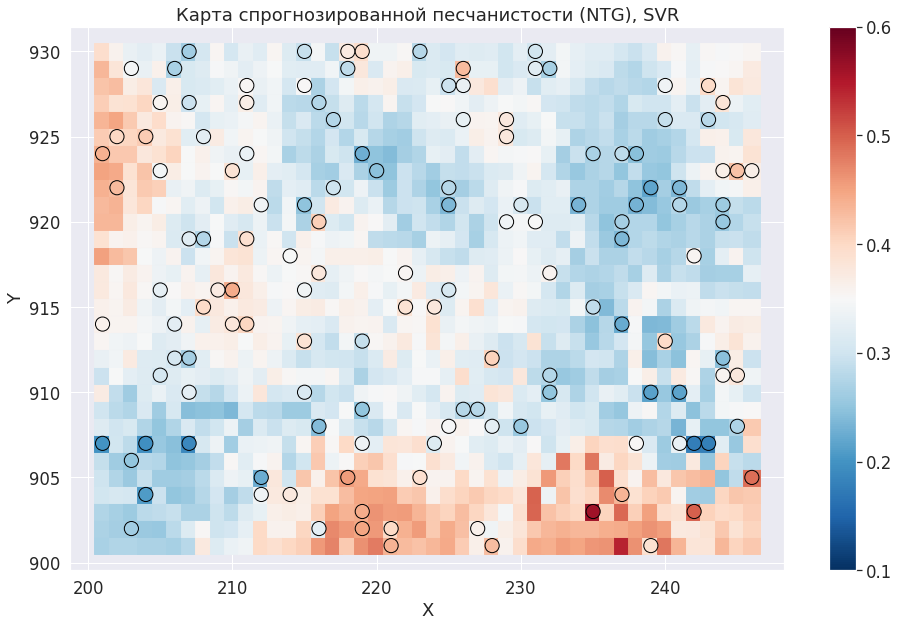

In [ ]:
predict_and_draw(data_predict, svr, model='SVR')

# Обобщение полученных результатов

В качестве сложной модели будм использовать Stacking Regressor

In [ ]:
from sklearn.ensemble import StackingRegressor

In [ ]:
estimators = [
    ('KNN', knn),
    ('BR', br),
    ('XGB', xgb),
]

In [ ]:
reg = StackingRegressor( estimators=estimators,final_estimator= RidgeCV(cv=5, scoring='neg_root_mean_squared_error', fit_intercept = True))

In [ ]:
%%time
reg.fit(X, y)

Fitting 5 folds for each of 5184 candidates, totalling 25920 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 1084 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 8828 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done 21820 tasks      | elapsed:   42.4s
[Parallel(n_jobs=-1)]: Done 25920 out of 25920 | elapsed:   50.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 540 candidates, totalling 2700 fits


[Parallel(n_jobs=-1)]: Done 156 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 924 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 2204 tasks      | elapsed:   28.5s
[Parallel(n_jobs=-1)]: Done 2700 out of 2700 | elapsed:   38.8s finished


[15:58:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Fitting 5 folds for each of 5184 candidates, totalling 25920 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 1084 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 8828 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done 21820 tasks      | elapsed:   43.1s
[Parallel(n_jobs=-1)]: Done 25917 out of 25920 | elapsed:   51.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 25920 out of 25920 | elapsed:   51.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 5184 candidates, totalling 25920 fits


[Parallel(n_jobs=-1)]: Done 1084 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 8828 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done 21820 tasks      | elapsed:   44.1s
[Parallel(n_jobs=-1)]: Done 25920 out of 25920 | elapsed:   52.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 5184 candidates, totalling 25920 fits


[Parallel(n_jobs=-1)]: Done 468 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 4340 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 10836 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done 19892 tasks      | elapsed:   41.2s
[Parallel(n_jobs=-1)]: Done 25920 out of 25920 | elapsed:   53.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 5184 candidates, totalling 25920 fits


[Parallel(n_jobs=-1)]: Done 668 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 4540 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 11036 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done 24700 tasks      | elapsed:   47.5s
[Parallel(n_jobs=-1)]: Done 25920 out of 25920 | elapsed:   49.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 5184 candidates, totalling 25920 fits


[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 8248 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 21240 tasks      | elapsed:   40.9s
[Parallel(n_jobs=-1)]: Done 25920 out of 25920 | elapsed:   49.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 540 candidates, totalling 2700 fits


[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 900 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done 2180 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done 2697 out of 2700 | elapsed:   35.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 2700 out of 2700 | elapsed:   35.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[16:03:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Fitting 5 folds for each of 540 candidates, totalling 2700 fits


[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 1788 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done 2700 out of 2700 | elapsed:   34.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[16:04:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Fitting 5 folds for each of 540 candidates, totalling 2700 fits


[Parallel(n_jobs=-1)]: Done 156 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 924 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 2204 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-1)]: Done 2700 out of 2700 | elapsed:   35.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[16:04:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Fitting 5 folds for each of 540 candidates, totalling 2700 fits


[Parallel(n_jobs=-1)]: Done 156 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 924 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 2204 tasks      | elapsed:   25.5s
[Parallel(n_jobs=-1)]: Done 2700 out of 2700 | elapsed:   34.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[16:05:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Fitting 5 folds for each of 540 candidates, totalling 2700 fits


[Parallel(n_jobs=-1)]: Done 156 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 924 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 2204 tasks      | elapsed:   25.7s


[16:05:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 2min 15s, sys: 1.79 s, total: 2min 17s
Wall time: 8min 42s


[Parallel(n_jobs=-1)]: Done 2700 out of 2700 | elapsed:   35.1s finished


StackingRegressor(cv=None,
                  estimators=[('KNN',
                               Pipeline(memory=None,
                                        steps=[('standardscaler',
                                                StandardScaler(copy=True,
                                                               with_mean=True,
                                                               with_std=True)),
                                               ('gridsearchcv',
                                                GridSearchCV(cv=5,
                                                             error_score=nan,
                                                             estimator=KNeighborsRegressor(algorithm='auto',
                                                                                           leaf_size=30,
                                                                                           metric='minkowski',
                                                 

In [ ]:
rmse(y, reg.predict(X))

0.05566217438726545

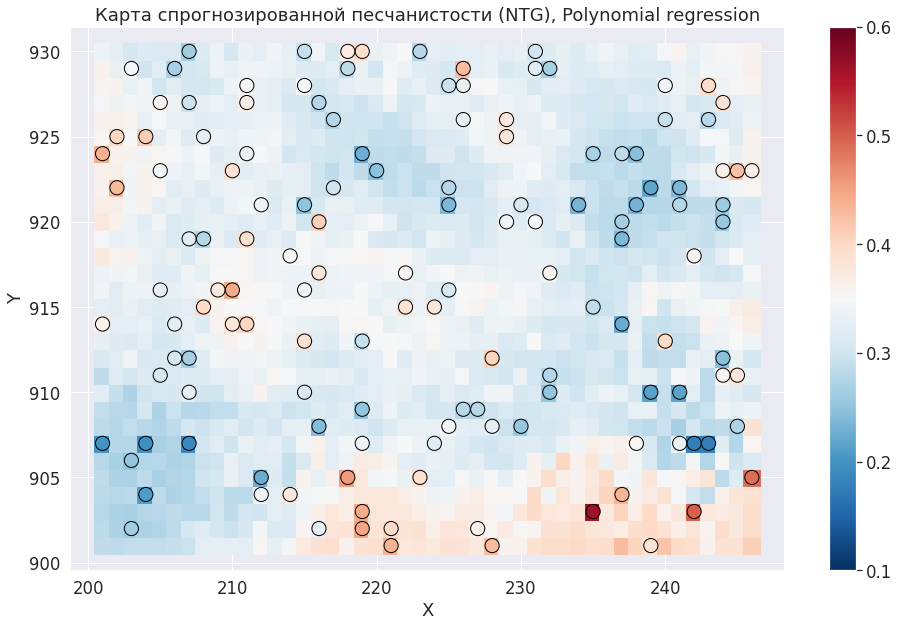

In [ ]:
predict_and_draw(data_predict, reg, model='Polynomial regression')